In [305]:
import torch
import torch.nn as nn
import pickle
import pandas as pd
from collections import defaultdict
from torch.utils.data import Dataset

In [306]:
df_cons_pop_cpi = pd.read_csv(
    './predicted_datas/2023-01~2032-12 미국소비, 인구수, cpi 예측.csv')
df_co2 = pd.read_csv('./predicted_datas/co2_2023_to_2032.csv')
df_oil = pd.read_csv('./predicted_datas/oil_price_2023_to_2032.csv')
df_sunlight = pd.read_csv('./predicted_datas/sunlight_2023_to_2032.csv')


In [307]:
df_co2.drop('Unnamed: 0', axis=1, inplace=True)
df_oil.drop('Unnamed: 0', axis=1, inplace=True)
df_sunlight.drop('Unnamed: 0', axis=1, inplace=True)

In [308]:
df_sunlight['state'] = ''
df_sunlight['state'] = df_sunlight.loc[:, 'AR':'SD'].idxmax(axis=1)
df_sunlight.drop(['AR', 'CA', 'IA', 'IL', 'MN', 'ND', 'NE', 'SD', 'LA'], axis=1, inplace=True)
df_sunlight

,sunlight_svm,ID,state
0,162.101379,2023-01,AR
1,176.387573,2023-02,AR
2,216.071960,2023-03,AR
3,247.411484,2023-04,AR
4,292.668579,2023-05,AR
...,...,...,...
1075,314.879730,2032-08,SD
1076,254.103409,2032-09,SD
1077,214.150681,2032-10,SD
1078,154.362915,2032-11,SD


In [309]:
merge_df = df_sunlight.merge(df_co2, on='ID', how='outer')
merge_df = merge_df.merge(df_oil, on='ID', how='outer')
merge_df = merge_df.merge(df_cons_pop_cpi, on='ID', how='outer')
merge_df.isnull().sum()

sunlight_svm                 0
ID                           0
state                        0
co2(ppm)                     0
oil_price                    0
food_consumption_us(kcal)    0
population_us_asian          0
cpi_us                       0
dtype: int64

In [310]:
# Column 순서 정렬
merge_df = merge_df.reindex(sorted(merge_df.columns), axis=1)

In [311]:
merge_df.drop(['state'], axis=1, inplace=True)

In [312]:
merge_df = merge_df.groupby('ID').mean()
merge_df = merge_df.reset_index()
merge_df['year'] = merge_df['ID'].str[:4]

In [313]:
merge_df


,ID,co2(ppm),cpi_us,food_consumption_us(kcal),oil_price,population_us_asian,sunlight_svm,year
0,2023-01,419.262543,286.64,3949.57,378.690826,25602660.30,150.876266,2023
1,2023-02,419.835022,286.79,3950.73,379.733093,25681029.73,174.442975,2023
2,2023-03,419.745361,286.74,3952.01,380.357025,25766986.21,216.450753,2023
3,2023-04,419.674316,286.48,3953.42,380.645782,25861507.06,248.526572,2023
4,2023-05,419.631866,286.13,3954.95,380.865570,25964986.22,289.957391,2023
...,...,...,...,...,...,...,...,...
115,2032-08,421.392609,261.56,4124.81,386.815582,30497368.09,297.563002,2032
116,2032-09,421.139038,261.53,4125.88,387.098755,30502296.81,247.342204,2032
117,2032-10,420.824738,261.51,4126.94,388.572723,30507060.14,214.973870,2032
118,2032-11,420.428223,261.48,4127.98,391.897125,30511658.08,155.809214,2032


In [314]:
corn_min_max_df = pd.read_csv('./minmax/Corn min max value.csv', index_col=0)
rice_min_max_df = pd.read_csv('./minmax/Rice min max value.csv', index_col=0)
spring_wheat_min_max_df = pd.read_csv(
    './minmax/Spring wheat min max value.csv', index_col=0)
winter_wheat_min_max_df = pd.read_csv(
    './minmax/Winter wheat min max value.csv', index_col=0)


In [315]:
min_max_df_list = [corn_min_max_df, rice_min_max_df,
                   spring_wheat_min_max_df, winter_wheat_min_max_df]


In [316]:
min_max_df_list[2]


,population_us_asian,cpi_us,co2(ppm),oil_price,sunlight_svm,food_consumption_us(kcal),productions
max,2.533703e+07,298.012000,420.99000,702.290743,421.5,4200.000000,1.270824e+07
min,1.111939e+05,8.664286,211.48788,3.836290,35.0,3007.102825,1.491437e+04


In [317]:
normalized_columns = ['population_us_asian', 'cpi_us',
                      'co2(ppm)', 'oil_price', 'sunlight_svm', 'food_consumption_us(kcal)']

df_list = []

for idx in range(4):
	new_df = merge_df.copy()
	for column in normalized_columns:
		max = min_max_df_list[idx].loc['max', column]
		min = min_max_df_list[idx].loc['min', column]
		new_df[column] = (new_df[column] - min) / (max - min) * (1.0 - 0.0001) + 0.0001
	df_list.append(new_df)


In [318]:
def make_data(df):
	# 각 'target' 값에 대응하는 'X' 값을 저장하기 위한 딕셔너리 생성
	X_dict = defaultdict(list)
	for _, row in df.iterrows():
			X = row.drop(['year', 'ID']).tolist()
			year = row['year']
			X_dict[year].append(X)

		# X와 y 분리
	years = df['year'].unique()
	X = [X_dict[year] for year in years]

	return X


In [319]:
input_X_list = []
for df in df_list:
    X_train = make_data(df)
    input_X_list.append(X_train)

In [320]:
class FieldCropsPredictionModel(nn.Module):
	def __init__(self, feature_num, filter_input_dim, filter_out_dim, hidden_dim, layer_num=2):
			super(FieldCropsPredictionModel, self).__init__()

			self.feature_num = feature_num

			self.filter_layers = nn.ModuleList()
			for i in range(feature_num):
				filter_layer = nn.Linear(filter_input_dim, filter_out_dim)
				nn.init.xavier_uniform_(filter_layer.weight)
				self.filter_layers.append(filter_layer)

			self.output_layer = nn.Linear(filter_out_dim, 1)

			nn.init.xavier_uniform_(self.output_layer.weight)

			self.hidden_layers = nn.ModuleList()
			for i in range(layer_num):
				hidden_layer = nn.Linear(
							feature_num if i == 0 else hidden_dim, hidden_dim if i != layer_num-1 else 1)
				nn.init.xavier_uniform_(hidden_layer.weight)
				self.hidden_layers.append(hidden_layer)

			self.activation_function = nn.ELU()

	def forward(self, input):
		batch_size, sequence_length, feature_size = input.size()

		outputs = []
		for i in range(batch_size):
			sequence = input[i]
			filtered_outputs = []

			for j in range(self.feature_num):
				feature = sequence[:, j]
				feature = feature.view(1, -1)
				filtered_feature = self.filter_layers[j](feature)
				filtered_feature = self.activation_function(filtered_feature)
				filtered_outputs.append(filtered_feature)

			sequence_out = torch.cat(filtered_outputs, dim= 0)
			sequence_out = sequence_out.t()

			for layer in self.hidden_layers:
				sequence_out = layer(sequence_out)
				sequence_out = self.activation_function(sequence_out)

			sequence_out = sequence_out.t()
			sequence_out = self.output_layer(sequence_out)
			sequence_out = self.activation_function(sequence_out)

			outputs.append(sequence_out)

		result = torch.stack(outputs, dim=0)
		return result

In [321]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

In [322]:
model = FieldCropsPredictionModel(6, 12, 10, 8, 3)
model.load_state_dict(torch.load('./models/Corn_train_model_50_epochs.pt'))
model.eval()

FieldCropsPredictionModel(
  (filter_layers): ModuleList(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): Linear(in_features=12, out_features=10, bias=True)
    (2): Linear(in_features=12, out_features=10, bias=True)
    (3): Linear(in_features=12, out_features=10, bias=True)
    (4): Linear(in_features=12, out_features=10, bias=True)
    (5): Linear(in_features=12, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (activation_function): ELU(alpha=1.0)
)

In [323]:
input_X_tensor_list = []

for input_X in input_X_list:
	tensor_list = []
	for X in input_X:
		tensor_X = torch.tensor(X)
		three_dim_tensor = torch.unsqueeze(tensor_X, 0)

		tensor_list.append(three_dim_tensor)
	
	input_X_tensor_list.append(tensor_list)

print(len(input_X_tensor_list[0]))

10


In [324]:
output_list = []

for input in input_X_tensor_list[0]:
	output = model(input)
	max = min_max_df_list[0].loc['max', 'productions']
	min = min_max_df_list[0].loc['min', 'productions']
	productions = (output - 0.0001) / (1.0 - 0.0001) * (max - min) + min
	output_list.append(productions)

In [328]:
for output in output_list:
    print(output.tolist()[0][0][0])

25701286.0
25744892.0
25811528.0
25876996.0
25940560.0
26001388.0
26058998.0
26112882.0
26162494.0
26207812.0


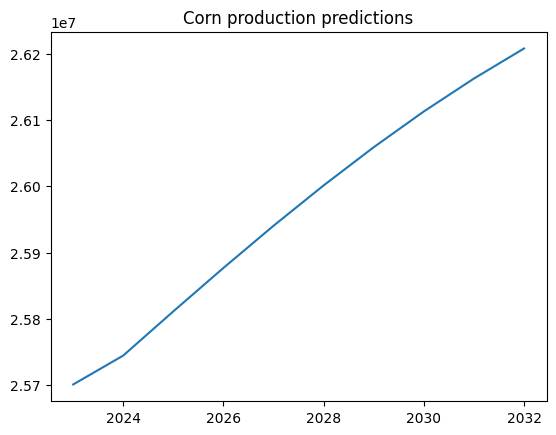

In [331]:
import matplotlib.pyplot as plt
import matplotlib.style as style

x = range(2023, 2033)
y = [output.tolist()[0][0][0] for output in output_list]
plt.plot(x, y, label='production')
plt.title('Corn production predictions')
plt.show()

1319915.875
1307254.125
1296469.5
1287210.375
1279384.375
1272858.625
1267422.375
1262889.375
1259090.375
1255904.125


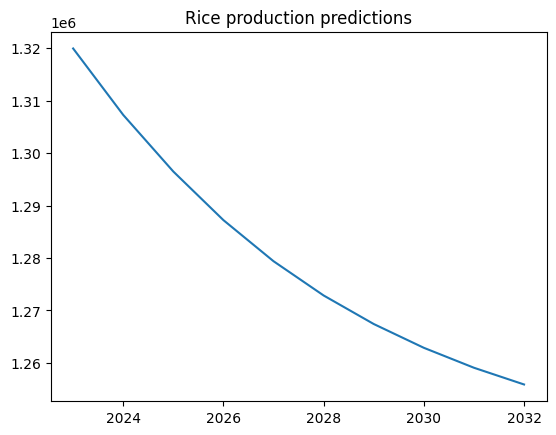

In [333]:
model.load_state_dict(torch.load('./models/Rice_train_model_50_epochs.pt'))
model.eval()

output_list = []

for input in input_X_tensor_list[1]:
	output = model(input)
	max = min_max_df_list[1].loc['max', 'productions']
	min = min_max_df_list[1].loc['min', 'productions']
	productions = (output - 0.0001) / (1.0 - 0.0001) * (max - min) + min
	output_list.append(productions)

for output in output_list:
    print(output.tolist()[0][0][0])
    
x = range(2023, 2033)
y = [output.tolist()[0][0][0] for output in output_list]
plt.plot(x, y, label='production')
plt.title('Rice production predictions')
plt.show()


2861981.5
2825601.5
2792093.5
2767533.0
2750548.5
2739279.0
2732267.0
2728296.25
2726382.5
2725797.25


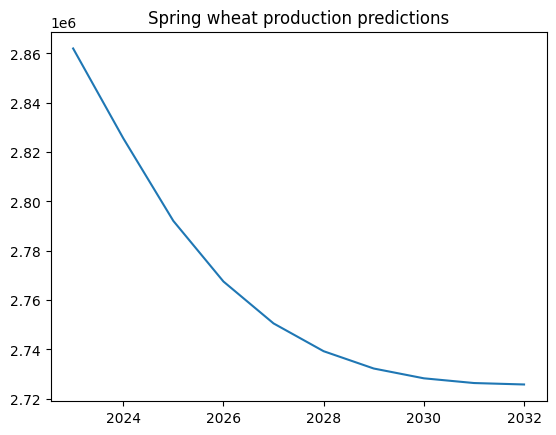

In [335]:
model.load_state_dict(torch.load('./models/Spring wheat_train_model_50_epochs.pt'))
model.eval()

output_list = []

for input in input_X_tensor_list[2]:
	output = model(input)
	max = min_max_df_list[2].loc['max', 'productions']
	min = min_max_df_list[2].loc['min', 'productions']
	productions = (output - 0.0001) / (1.0 - 0.0001) * (max - min) + min
	output_list.append(productions)

for output in output_list:
    print(output.tolist()[0][0][0])

x = range(2023, 2033)
y = [output.tolist()[0][0][0] for output in output_list]
plt.plot(x, y, label='production')
plt.title('Spring wheat production predictions')
plt.show()


1336457.375
1336786.125
1339813.875
1345136.75
1351186.5
1357848.25
1364889.125
1371906.875
1378647.375
1384889.375


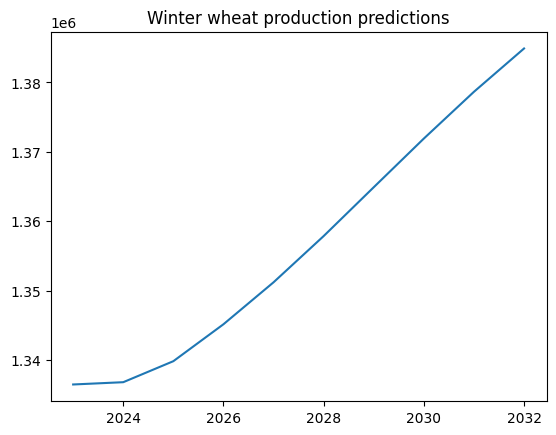

In [337]:
model.load_state_dict(torch.load(
	'./models/Winter wheat_train_model_50_epochs.pt'))
model.eval()

output_list = []

for input in input_X_tensor_list[2]:
	output = model(input)
	max = min_max_df_list[2].loc['max', 'productions']
	min = min_max_df_list[2].loc['min', 'productions']
	productions = (output - 0.0001) / (1.0 - 0.0001) * (max - min) + min
	output_list.append(productions)

for output in output_list:
    print(output.tolist()[0][0][0])

x = range(2023, 2033)
y = [output.tolist()[0][0][0] for output in output_list]
plt.plot(x, y, label='production')
plt.title('Winter wheat production predictions')
plt.show()
